---
# <div> COSC 2673/2793 | Machine Learning </div>
# <div> Assignment 2 (Part 1) Cancer Classifying Model </div>
    
---

Group 25:
* Sarang Kuniyil: s3914175
* Aayushi Khatri: s3948240    
---


## Table of Contents

* [Introduction](#introduction)
* [EDA](#eda)
* [Choice of Model](#choice)
* [Loading in images](#loading)
* [Preprocessing Data](#processing)
    * [Feature Scaling](#scaling)
    * [Data Splitting](#data_split)
* [Evaluation Framework](#evaluation)
* [Setting up Baseline Model](#baseline)
    * [Evaluating Baseline Model](#evaluating)
    * [Limitations of Baseline Model](#limitations)
* [Updating Baseline Model](#update)
    * [Evaluate Finetuning](#eval_fine)
    * [Regularisation](#regular)
    * [Evaluating Updated Model](#eval_regular)
* [Testing the Updated Model](#test)
* [Ultimate Judgement & Conclusions](#conclusion)
* [References](#references)

---

## Introduction <a class="anchor" id="introduction"></a>

This report aims to develop a machine learning model that can accurately classify histopathology images of cancerous cells using a modified version of the CRCHistoPhenotypes dataset. The dataset consists of 27x27 RGB images of cells from 99 different patients.

## Loading in CSV file with labels

In [1]:
# Importing all the relevant modules
import tensorflow as tf
import os

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from matplotlib import pyplot as plt
import cv2
import imghdr

In [4]:
# Variable stores the name of folder where all the image files are
data_dir = 'patch_images' 

In [5]:
# Reading in data labels for the main data set and storing it in a data frame
df = pd.read_csv('./data_labels_mainData.csv')

In [6]:
df

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


## EDA (Exploratory Data Analysis) <a class="anchor" id="eda"></a>

To identify other trends in the data, we will examine the data frame as it is easier to work with and will help visualise trends that are harder to see when analysing images. Let's look at the distribution of the isCancerous variable first.

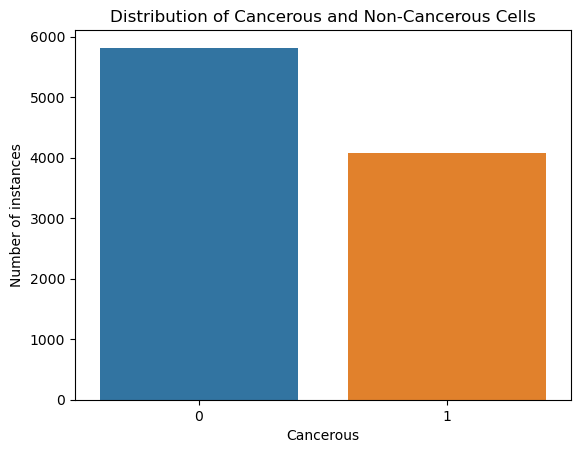

In [7]:
# Plotting the distribution of cancerous and malignant cells
sns.countplot(x="isCancerous", data=df)

# Adding title and axes labels
plt.xlabel("Cancerous")
plt.ylabel("Number of instances")
plt.title("Distribution of Cancerous and Non-Cancerous Cells")
plt.show()

From the bar chart is the clear that there are more instances of cancerous images than non-cancerous.

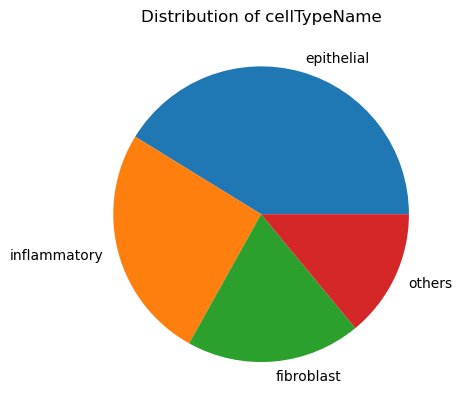

In [8]:
# Count the number of instances for each value in the column
value_counts = df['cellTypeName'].value_counts()

# Create a pie chart
plt.pie(value_counts.values, labels=value_counts.index)

# Adding title
plt.title('Distribution of cellTypeName')
plt.show()

From the above pie chart, it can be seen that there is not an equal number of samples for the various cell types either, with epithelial having the most number of impressions.

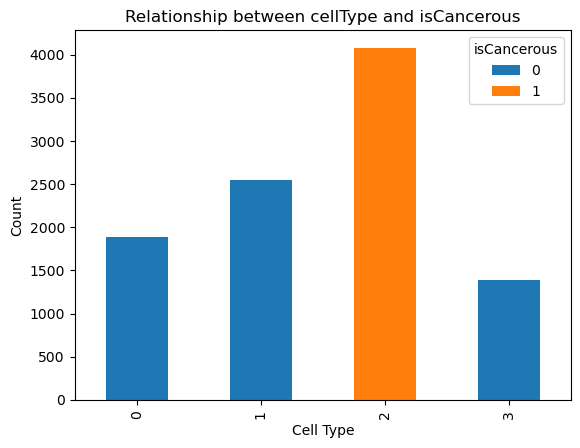

In [9]:
# Creating a pivot table with the count of isCancerous for each cellType
pivot_df = df.loc[:, ['cellType', 'isCancerous']]
pivot_df = pivot_df.pivot_table(index='cellType', columns='isCancerous', aggfunc=len, fill_value=0)

# Plotting the stacked bar chart
pivot_df.plot(kind='bar', stacked=True)

# Adding title and axes labels
plt.title('Relationship between cellType and isCancerous')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.show()

From the bar chat above, it can be seen that all epithelial cells in this data set are cancerous. However, real world papers suggest that this is not a good rule of thumb as everyone has epithelial cells and they are usually malginant. It is possible that the model might learn to associate epithelial cell as being cancerous and this might lead to issues when deploying the model into the real world.  

## Choice of Baseline Model <a class="anchor" id="choice"></a>

The Convolutional Neural Network (CNN) deep learning model is a highly effective approach for image classification tasks, making it an appropriate baseline model for this task. 

## Loading in Images <a class="anchor" id="loading"></a>

In [10]:
# Only storing the imageName and isCancerous label 
# As they are the only relevant independent features for this model
df_cancer = df.loc[:, ['ImageName', 'isCancerous']]

In [11]:
df_cancer

,ImageName,isCancerous
0,22405.png,0
1,22406.png,0
2,22407.png,0
3,22408.png,0
4,22409.png,0
...,...,...
9891,1625.png,1
9892,1626.png,1
9893,1627.png,1
9894,1628.png,1


In [12]:
# Getting the order of the images in the directory
image_names = os.listdir(data_dir)

In [13]:
# Only saving the images that we have labels for (from the csv file)
df_cancer = df_cancer[df_cancer['ImageName'].isin(image_names)]

In [14]:
# Extracting the number value of the imageName and converting it to an integer
df_cancer['ImageName'] = df_cancer['ImageName'].str.extract(r'(\d+)').astype(int)  

The cell below does not produce an output any longer because the directories for cancerous and non-cancerous cells have already been made. 

In [ ]:
# Sorting the numbers in ascending order to match directory
df_sorted = df_cancer.sort_values('ImageName')
df_sorted["ImageName"] = df_sorted["ImageName"].astype(str)
df_sorted

The following code was used to separate the images that we have labels for into Cancerous and Non-Cancerous directories. The labels were crucial in helping the model learn which images were actually cancerous and which weren't, in order to reasonably classify unseen images.

The code has been included purely so readers can ascertain the way in which we separated the data set. Please do not run this code again because the image directories have already been made. Thus, this code will not actually produce any output. 

In [ ]:
import shutil

# list of images we don't have labels for
invalid_list = []

# define source directorie
src_dir = "patch_images"

# define destination directory
dst_dir_cancerous = "cancerous_images"
dst_dir_noncancerous = "noncancerous_images"

# loop through each image in the source directory
for filename in os.listdir(src_dir):
    # get the image path
    img_path = os.path.join(src_dir, filename)
    
    # get the corresponding label from the dataframe
    label_df = df_sorted.loc[df_sorted["ImageName"] + ".png" == filename]
    if label_df.empty:
        invalid_list.append(filename)
        continue
    label = label_df.values.tolist()[0][1]
    
    # move the image to the appropriate destination directory based on the label
    if label == 1:
        shutil.move(img_path, dst_dir_cancerous)
    else:
        shutil.move(img_path, dst_dir_noncancerous)


### Creating an image data set <a class="anchor" id="image_data"></a>

In [15]:
# Building the data pipeline
data = tf.keras.utils.image_dataset_from_directory('data')

Found 9896 files belonging to 2 classes.


We then created a data iterator that will iterate through the images, as the name suggests. This will help us access the data pipeline.

In [16]:
# Creating a data_iterator
data_iterator = data.as_numpy_iterator()

In [17]:
# Allows us to loop through the data in batches. It returns the current batch
batch = data_iterator.next()

In [18]:
# Images represented as Numpy arrays
# There are 32 images in each batch by default, we have not changed that value yet. 
batch[0].shape

(32, 256, 256, 3)

In [19]:
# Printing out the label of images in the first batch
batch[1]

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0])

According to a paper published in the Comput Methods Programs Biomed, histopathologists visually examine the regularities of cell shapes and tissue distributions from the histopathology images, and decide whether tissue regions are cancerous, and determine the malignancy level. Let us plot some images from the first batch of our data set.

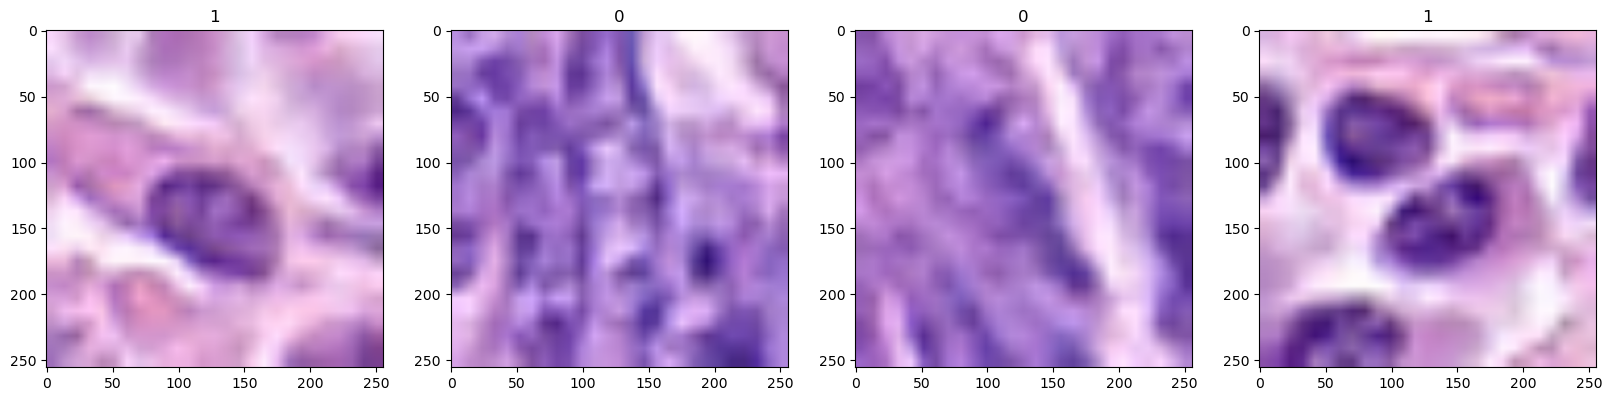

In [20]:
# plotting images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    
    # assigning the title to the image label
    ax[idx].title.set_text(batch[1][idx])

For the untrained eye, it is hard to identify the factors that classify the above images as cancerous. However, with exposure to mutliple data points, we expect the model to reasonably predict whether the cells are cancerous or malignant.

Next we need to determine whether both classes have roughly the same number of images. Although we checked the distrubution in the EDA, we do not have images for all the labels. So, we must get the distribution of the images again to check the split.

In [21]:
# Getting class categories from the data
class_names = sorted(os.listdir('data'))

# Getting the count of images in each class
class_counts = dict(zip(class_names, [0]*len(class_names)))
for images, labels in data:
    for label in labels.numpy():
        label_name = class_names[label]
        class_counts[label_name] += 1

print(class_counts)

{'cancerous_images': 4079, 'noncancerous_images': 5817}


There are 17.56% more non-cancerous images than there are cancerous images. Although the split is almost even, this might be an issue when the model trains as it might have the tendency to predict an image is non-cancerous. The unbalanced classes will also inform the ussage of evaluation metrics when it comes to tranining and assessing the model.

## Preprocessing Data <a class="anchor" id="processing"></a>

### Scaling Data <a class="anchor" id="scaling"></a>

We scaled the data so all the values were between 0 and 1. This was a time-saving measure, as the CNN would be able to run a lot faster with smaller values.

In [22]:
# Transforming the data in the pipeline
# x is the image
# y is the target variable, the label
# We are dividing by 255 so the values are between 0 and 1
data = data.map(lambda x,y: (x/255, y))

In [23]:
data.as_numpy_iterator().next()

(array([[[[1.        , 0.94509804, 1.        ],
          [1.        , 0.94509804, 1.        ],
          [1.        , 0.94509804, 1.        ],
          ...,
          [0.73333335, 0.5921569 , 0.73333335],
          [0.73333335, 0.5921569 , 0.73333335],
          [0.73333335, 0.5921569 , 0.73333335]],
 
         [[1.        , 0.94509804, 1.        ],
          [1.        , 0.94509804, 1.        ],
          [1.        , 0.94509804, 1.        ],
          ...,
          [0.73333335, 0.5921569 , 0.73333335],
          [0.73333335, 0.5921569 , 0.73333335],
          [0.73333335, 0.5921569 , 0.73333335]],
 
         [[1.        , 0.94509804, 1.        ],
          [1.        , 0.94509804, 1.        ],
          [1.        , 0.94509804, 1.        ],
          ...,
          [0.73333335, 0.5921569 , 0.73333335],
          [0.73333335, 0.5921569 , 0.73333335],
          [0.73333335, 0.5921569 , 0.73333335]],
 
         ...,
 
         [[0.9764706 , 0.8666667 , 0.9529412 ],
          [0.97647

### Splitting Data <a class="anchor" id="data_split"></a>

We need to divide our data into three data sets to train, validate and test the model. Here, we are fiding out the total amount of batches in our data set. 

In [24]:
print(f"Total number of batches in the data set are: {len(data)}.")

Total number of batches in the data set are: 310.


We will use the 60-20-20% splitting approach. 

In [25]:
# training data that the model learns on
train_size = int(len(data)*.6)

# validation data that the model uses to test itself while still training
val_size = int(len(data)*.2)

# data used to evaluate how the model does post training
test_size = int(len(data)*.2)

In [26]:
# printing out the batch size of each data set
print(f"Train Size: {train_size}, Validation Size: {val_size}, Testing Size: {test_size}")

Train Size: 186, Validation Size: 62, Testing Size: 62


In [27]:
# splitting the main data set into three

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Evaluation Framework <a class="anchor" id="evaluation"></a>

The three evaluation metrics we will use to assess the success of the model are:
* `Loss`
* `F1 Score`
* We call `Precision` and `Recall` to calculate the F1 Score, as seen in the function below. 

For the, we expect to see an `F1 Score` of `0.85` and `loss` of `0.30`.

In [28]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(y_true * y_pred))
    predicted_positives = K.sum(K.round(y_pred))
    actual_positives = K.sum(K.round(y_true))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

## Setting up Baseline Model <a class="anchor" id="baseline"></a>

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [30]:
model = Sequential()

We will be using the `ReLU` activation function for the all layers of the model apart from the last one. The final layer's output is used to determine whether the picture shows a cancerous cell or not. Hence, a `Sigmoid` function is used because it is most appropriate for binary classification problems.

In [31]:
# First layer is the input layer, and its a convolution layer. the filter is 3x3 pixels
# We are using the ReLU Activation Function
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))

# Will get the max value and condense that information
model.add(MaxPooling2D())

# First hidden layer
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Second hidden layer
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Getting a single value by the flattening
model.add(Flatten())

# 256 neurons
model.add(Dense(256, activation='relu'))

# The final layer outputs whether the picture shows a cancerous cell or not
# Sigmoid function is used because it is most appropriate for binary classification
model.add(Dense(1, activation='sigmoid'))

Compiling the model.

In [32]:
model.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=[f1_score])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

### Training the Baseline Model

In [34]:
from keras.callbacks import TensorBoard, EarlyStopping
logdir = "logs/"
tensorboard_callback = TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
186/186 [==============================] - 160s 857ms/step - loss: 0.6301 - f1_score: 0.7265 - val_loss: 0.5609 - val_f1_score: 0.7750
Epoch 2/20
186/186 [==============================] - 143s 769ms/step - loss: 0.5284 - f1_score: 0.7788 - val_loss: 0.5365 - val_f1_score: 0.7899
Epoch 3/20
186/186 [==============================] - 144s 771ms/step - loss: 0.4422 - f1_score: 0.8340 - val_loss: 0.3084 - val_f1_score: 0.8918
Epoch 4/20
186/186 [==============================] - 153s 824ms/step - loss: 0.3148 - f1_score: 0.8867 - val_loss: 0.3148 - val_f1_score: 0.8687
Epoch 5/20
186/186 [==============================] - 148s 792ms/step - loss: 0.2852 - f1_score: 0.8976 - val_loss: 0.3108 - val_f1_score: 0.8996
Epoch 6/20
186/186 [==============================] - 147s 790ms/step - loss: 0.2793 - f1_score: 0.9019 - val_loss: 0.3393 - val_f1_score: 0.8665
Epoch 7/20
186/186 [==============================] - 146s 782ms/step - loss: 0.2713 - f1_score: 0.9077 - val_loss: 0.2696 -

### Evaluating Baseline Model <a class="anchor" id="evaluating"></a>

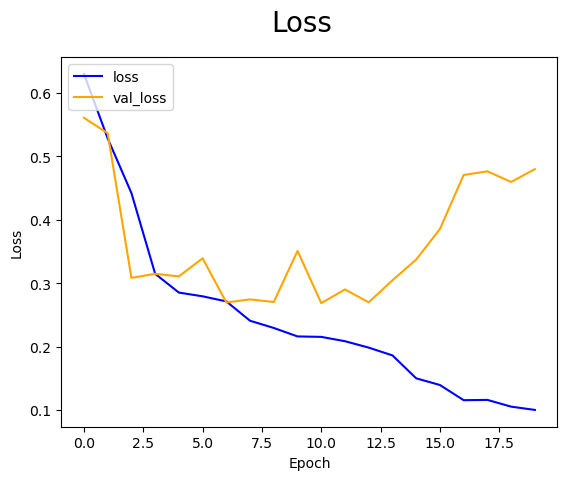

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

From the line graph it is evident that the model is overfitting. The gap between `loss` and `val_loss` indicates that the model is not able to generalise on new data. The gap increases significantly around the 10th epoch. 

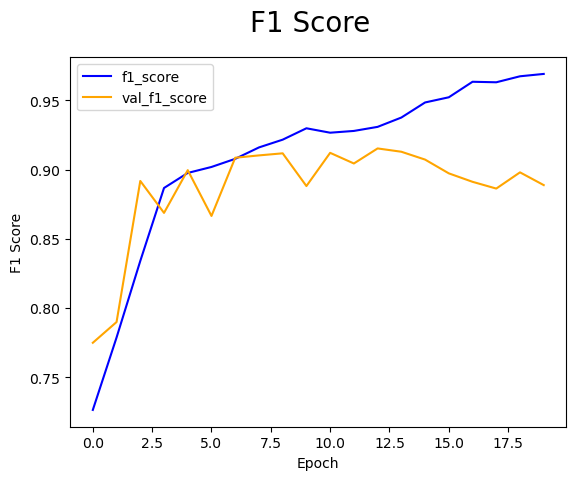

In [37]:
fig = plt.figure()
plt.plot(hist.history['f1_score'], color='blue', label='f1_score')
plt.plot(hist.history['val_f1_score'], color='orange', label='val_f1_score')
fig.suptitle('F1 Score', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc="upper left")
plt.show()

The `F1 score` graph also shows that the model is overfitting because as the `f1_score` increases after epoch 12, the `val_f1_score` decreases by approximately 0.10.

## Limitations of Baseline Model <a class="anchor" id="limitations"></a>

Overfitting refers to the phenomenon where the model becomes too specialised in learning the training data, resulting in poor generalisation to new, unseen data. In the context of the observed gap between training and validation metrics, it suggests that the model is fitting the training data too well but fails to generalize effectively to the validation data. This limitation can hinder the model's performance when applied to real-world scenarios or unseen data.

Additionally, the lack of hyperparameter tuning can contribute to suboptimal results and further widen the gap between the training `loss` and `f1_score` and the validation `loss` and `f1_score`. Optimal hyperparameters, including the number of epoch, regularization parameters, dropout layers etc. can significantly impact the model's performance and ability to generalise. Without finding the right combination of hyperparameter values, the model may not achieve its full potential, exhibiting a noticeable discrepancy between the training and validation metrics.

## Updating Baseline Model <a class="anchor" id="update"></a>

Considering that the `val_f1_score` is relatively high, standing at `0.8888` even with overfitting, we believe that CNN is an appropriate choice of a machine learning model for this problem. However, it still has its limitations. Therefore, in an attempt to address the issue of overfitting, we will fine a parameter:

* Epochs - Firstly, epochs are defined as the the total number of iterations of all the training data in one cycle for training the machine learning model. For the baseline model, this was set to an arbitrary number of `20`. However, this lead to overfitting. Therefore, we will use an technique called early-stopping. This will keep running the model until there is no consecutive improvement in the `val_f1_score` for a defined patience value (`5` in this case). 

We will also try to improve the performance of the model by:

* Regularisation - To comabat overfitting, a dropout layer will be added to the model in an attempt to not overcomplicate it. A dropout layer will randomly 'drop out' (set to zero) a proportion of the neurons in a layer during training. By applying dropout, the model learns to be more robust and less dependent on any individual neuron. It prevents neurons from excessively co-adapting to each other, instead, forcing them to independently learn features in the data. 

Adding early stopping to the model.

In [38]:
from keras.callbacks import TensorBoard, EarlyStopping
logdir = "logs/"
tensorboard_callback = TensorBoard(log_dir=logdir)
earlystop_callback = EarlyStopping(patience=5, monitor='val_loss')

In [39]:
hist = model.fit(train, 
                 epochs=50, validation_data=val, 
                 callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/50
186/186 [==============================] - 149s 800ms/step - loss: 0.0903 - f1_score: 0.9757 - val_loss: 0.4655 - val_f1_score: 0.9039
Epoch 2/50
186/186 [==============================] - 141s 755ms/step - loss: 0.0673 - f1_score: 0.9809 - val_loss: 0.5429 - val_f1_score: 0.8909
Epoch 3/50
186/186 [==============================] - 139s 746ms/step - loss: 0.0619 - f1_score: 0.9817 - val_loss: 0.6619 - val_f1_score: 0.8791
Epoch 4/50
186/186 [==============================] - 140s 750ms/step - loss: 0.0653 - f1_score: 0.9797 - val_loss: 0.5797 - val_f1_score: 0.9001
Epoch 5/50
186/186 [==============================] - 137s 736ms/step - loss: 0.0587 - f1_score: 0.9848 - val_loss: 0.7990 - val_f1_score: 0.8767
Epoch 6/50
186/186 [==============================] - 137s 735ms/step - loss: 0.0472 - f1_score: 0.9866 - val_loss: 0.7232 - val_f1_score: 0.8723


The model stoppped training after epoch 6.

### Evaluate Finetuning (early stop) <a class="anchor" id="eval_fine"></a>

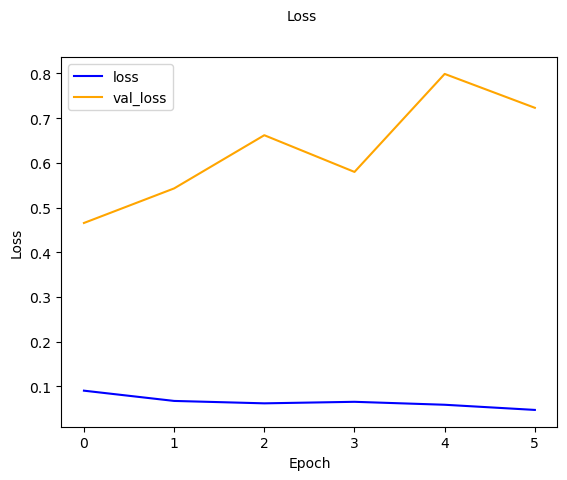

In [40]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

While earlystopping is widely regarded to be a technique used to prevent overfitting and save computational time and resources, in this instance it has had the opposite effect. The gap between the training and validation `loss` is still quite large. 

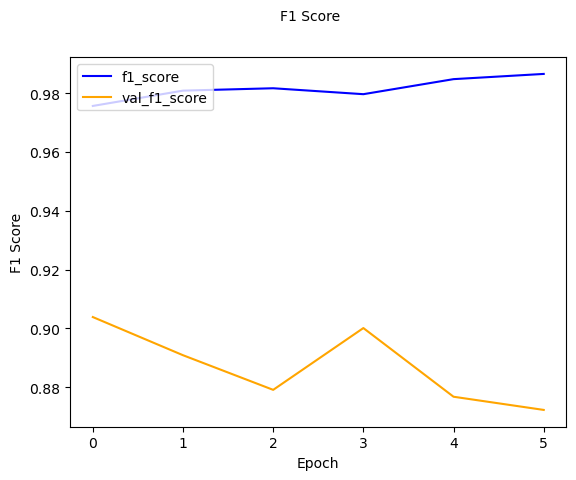

In [41]:
fig = plt.figure()
plt.plot(hist.history['f1_score'], color='blue', label='f1_score')
plt.plot(hist.history['val_f1_score'], color='orange', label='val_f1_score')
fig.suptitle('F1 Score', fontsize=10)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc="upper left")
plt.show()

While the `F1 score` for the training and validation data is relatively high, a gap between the two still exists. This further confirms the need for regularisation. 

### Regularisation <a class="anchor" id="regular"></a>

Now we will update the baseline model to include regularisation, by adding a dropout layer, as previously mentioned. We will continue to use early-stopping however, as it reduces computational overheads. 

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

drop_model = Sequential()

drop_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
drop_model.add(MaxPooling2D())

drop_model.add(Conv2D(32, (3,3), 1, activation='relu'))
drop_model.add(MaxPooling2D())

drop_model.add(Conv2D(16, (3,3), 1, activation='relu'))
drop_model.add(MaxPooling2D())

drop_model.add(Flatten())

drop_model.add(Dense(256, activation='relu'))

# Add Dropout layer with a rate of 0.5
drop_model.add(Dropout(0.5))

drop_model.add(Dense(1, activation='sigmoid'))

Compiling new model.

In [43]:
drop_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_score])

In [50]:
drop_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

Adding callbacks, following the same method as the baseline model.

In [44]:
logdir = "logs/"
tensorboard_callback = TensorBoard(log_dir=logdir)
earlystop_callback = EarlyStopping(patience=5, monitor='val_loss')

Training the new model.

In [45]:
hist = drop_model.fit(train, 
                 epochs=50, validation_data=val, 
                 callbacks=[tensorboard_callback, earlystop_callback])


Epoch 1/50
186/186 [==============================] - 136s 725ms/step - loss: 0.4671 - f1_score: 0.8079 - val_loss: 0.3789 - val_f1_score: 0.8624
Epoch 2/50
186/186 [==============================] - 139s 745ms/step - loss: 0.3361 - f1_score: 0.8812 - val_loss: 0.3755 - val_f1_score: 0.8284
Epoch 3/50
186/186 [==============================] - 140s 752ms/step - loss: 0.3186 - f1_score: 0.8801 - val_loss: 0.4521 - val_f1_score: 0.8367
Epoch 4/50
186/186 [==============================] - 140s 752ms/step - loss: 0.3242 - f1_score: 0.8831 - val_loss: 0.2679 - val_f1_score: 0.9040
Epoch 5/50
186/186 [==============================] - 138s 743ms/step - loss: 0.2901 - f1_score: 0.8949 - val_loss: 0.2669 - val_f1_score: 0.9021
Epoch 6/50
186/186 [==============================] - 143s 766ms/step - loss: 0.2867 - f1_score: 0.8973 - val_loss: 0.2728 - val_f1_score: 0.9000
Epoch 7/50
186/186 [==============================] - 138s 742ms/step - loss: 0.2679 - f1_score: 0.9040 - val_loss: 0.2581 -

The early-stopping callback has stopped the model at `epoch 14`. This is a greater number of epochs than we have seen previously, and potentially indicates that due to regularisation, the model requires more passes of the data.

### Evaluating Model with Dropout <a class="anchor" id="eval_regular"></a>

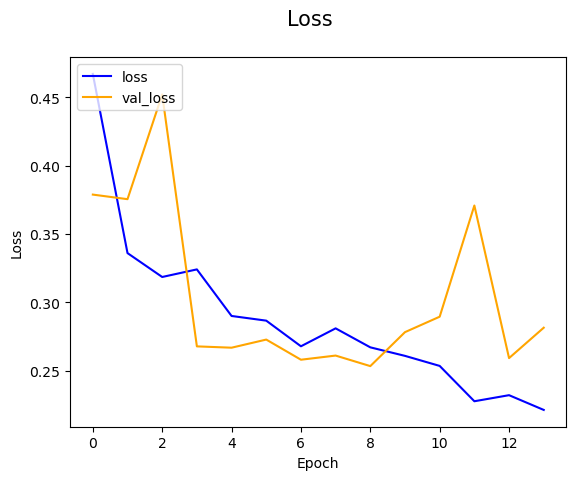

In [46]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=15)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

Already, we can see the effects of over-fitting have been reduced. The `val_loss` has also decreased from `0.7407` (in the earlystopping baseline model) to `0.2728` (in the updated model with dropout), which is a significant improvement. There is a spike of higher `val_loss` during epoch 11, and we assume that this can be combatted with a smaller patience value in the early stopping callback. However, it did not seem to make much difference in the final `val_loss` and `val_f1_score` so we have not changed the patience value.  

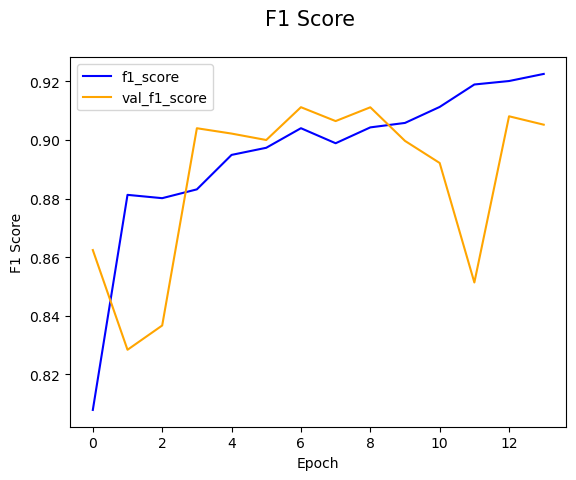

In [47]:
fig = plt.figure()
plt.plot(hist.history['f1_score'], color='blue', label='f1_score')
plt.plot(hist.history['val_f1_score'], color='orange', label='val_f1_score')
fig.suptitle('F1 Score', fontsize=15)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc="upper left")
plt.show()

The `val_f1_score` has increased from `0.8963` to `0.9205`, which is not a massive improvement. However, since the gap between the `f1_score` and the `val_f1_score` has reduced significantly, we can conclude that the model has performed better. There is spike in the `val_f1_score` during epoch 11. This is once again due to the patience value, however we will not be changing it as we noticed no major improvements to the model.

## Testing the Updated Model <a class="anchor" id="test"></a>

We have now assumed that the model has reached the best performance we can achieve. 

Let us see how the model predicts if an image is cancerous or benign on unseen data. We will be using the `test` data set.

In [48]:
test_loss, test_f1 = drop_model.evaluate(test)
print('Test Loss:', test_loss)
print('Test F1 Score:', test_f1)

62/62 [==============================] - 16s 171ms/step - loss: 0.3017 - f1_score: 0.9056
Test Loss: 0.3016645610332489
Test F1 Score: 0.905576229095459


This model has produced the lowest `loss` score we have seen so far. The `f1_score` is also quite high, indicating that the model can reasonably predict whether an image if cancerous or not.

## Ultimate Judgement and Conclusions
### (Cancer Classification Model) <a class="anchor" id="conclusion"></a>

Therefore, the final model meets the evaluation framework. The `loss` is `0.3017`, which is the lowest we have seen so far and it meets the prediction of the `loss` being 0.30. This indicates that the model is able to minimise the discrepancy between the predicted and actual values. The `f1_score` is 0.9056 which is more than the expected 0.85 `f1_score`. This indicates that the model effectively predicts whether an image is cancerous or not. 

Based on these findings, it can be concluded that the model has performed welll and achieved a high level of accuracy in classifying cancerous and non-cancerous cells. It demonstrates a strong predictive capability and meets the expected performance thresholds outlined in the framework and is therefore the ultimate judgement for this task. 

---

## References <a class="anchor" id="references"></a>

* Basha, S.H.S., Dubey, S.R., Pulabaigari, V. and Mukherjee, S. (2019). Impact of fully connected layers on performance of convolutional neural networks for image classification. Neurocomputing, 378. doi:https://doi.org/10.1016/j.neucom.2019.10.008.
* Javed, S., Mahmood, A., Dias, J. and Werghi, N. (2022). Multi-level feature fusion for nucleus detection in histology images using correlation filters. Computers in Biology and Medicine, [online] 143, p.105281. doi:https://doi.org/10.1016/j.compbiomed.2022.105281.
* Jung, H., Lodhi, B. and Kang, J. (2019). An automatic nuclei segmentation method based on deep convolutional neural networks for histopathology images. BMC Biomedical Engineering, [online] 1(1). doi:https://doi.org/10.1186/s42490-019-0026-8.
* Li, S., Jiang, H. and Pang, W. (2017). Joint multiple fully connected convolutional neural network with extreme learning machine for hepatocellular carcinoma nuclei grading. Computers in Biology and Medicine, 84, pp.156–167. doi:https://doi.org/10.1016/j.compbiomed.2017.03.017.
* Renotte, N. (2022). nicknochnack/ImageClassification. [online] GitHub. Available at: https://github.com/nicknochnack/ImageClassification.
* Shabbeer Basha, S.H., Ghosh, S., Kishan Babu, K., Ram Dubey, S., Pulabaigari, V. and Mukherjee, S. (2018). RCCNet: An Efficient Convolutional Neural Network for Histological Routine Colon Cancer Nuclei Classification. 2018 15th International Conference on Control, Automation, Robotics and Vision (ICARCV). doi:https://doi.org/10.1109/icarcv.2018.8581147.
* Sirinukunwattana, K., Raza, S.E.A., Tsang, Y.-W., Snead, D.R.J., Cree, I.A. and Rajpoot, N.M. (2016). Locality Sensitive Deep Learning for Detection and Classification of Nuclei in Routine Colon Cancer Histology Images. IEEE Transactions on Medical Imaging, 35(5), pp.1196–1206. doi:https://doi.org/10.1109/tmi.2016.2525803.
* Statnikov, A., Wang, L. and Aliferis, C.F. (2008). A comprehensive comparison of random forests and support vector machines for microarray-based cancer classification. BMC Bioinformatics, 9(1), p.319. doi:https://doi.org/10.1186/1471-2105-9-319.
* van der Laak, J., Litjens, G. and Ciompi, F. (2021). Deep learning in histopathology: the path to the clinic. Nature Medicine, 27(5), pp.775–784. doi:https://doi.org/10.1038/s41591-021-01343-4.
* Wahab, N., Khan, A. and Lee, Y.S. (2017). Two-phase deep convolutional neural network for reducing class skewness in histopathological images based breast cancer detection. Computers in Biology and Medicine, 85, pp.86–97. doi:https://doi.org/10.1016/j.compbiomed.2017.04.012.
